# Python profiling and Unconstrained Optimization


## Python profiling
Based on [Julien Danjou Blog post on Profiling Python using cProfile](https://julien.danjou.info/guide-to-python-profiling-cprofile-concrete-case-carbonara/) and [Matt Gormley's Lecture notes](http://www.cs.cmu.edu/~mgormley/courses/606-607-f18/slides607/lecture11-inference.pdf) **slides 61-67**.



In [4]:
import cProfile
cProfile.run('2 + 2')

         3 function calls in 0.000 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.000    0.000 <string>:1(<module>)
        1    0.000    0.000    0.000    0.000 {built-in method builtins.exec}
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}




## Unconstrained optimization

Based on [Geoff Gordon's Optimization in ML lecture notes](https://qna.cs.cmu.edu/#/pages/view/99) and [Matt Gormley's Unconstrained Optimization slides](http://www.cs.cmu.edu/~mgormley/courses/606-607-f18/slides607/lecture12-opt.pdf).

Often, any ML problem is cast in terms of an optimization problem.

Example: Least square problem.

- Define objective function
- Solve unconstrained optimization problem via favorite method (closed form, GD, SGD...)
- Use learned model to predict

Review:
- Derivatives, gradient, hessian
- Convex, concave, non-convex functions (see these [scribe notes from Ryan Tibshirani's 10-725](http://www.stat.cmu.edu/~ryantibs/convexopt/scribes/convex-fns-scribed.pdf) section 2.3)
- gradient = 0, what does it correspond to?

Solving LS problem:
- random guess
- closed form solution (compute $(X^\top X)^{-1}X^\top y)$, but this might be too expensive, $O(M^2N+M^{2.373})$
- gradient descent

In [147]:
# Gradient Computation for Linear regression

from sklearn import datasets
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore
%matplotlib inline

# X, y = datasets.load_diabetes(return_X_y=True)
data = datasets.load_diabetes()
data['data'] = np.nan_to_num(zscore(data['data']))
# train data
X = data['data'][:300,np.array([0,1])]
y = X.dot(np.array([0.4,0.7]))+0.8*np.random.normal(size=300)
# validation data
Xval = data['data'][300:350,np.array([0,1])]
yval = Xval.dot(np.array([0.4,0.7]))+0.8*np.random.normal(size=50)
# test data
Xtest = data['data'][350:400,np.array([0,1])]
ytest = Xtest.dot(np.array([0.4,0.7]))+0.8*np.random.normal(size=50)

(300, 2)
(300,)


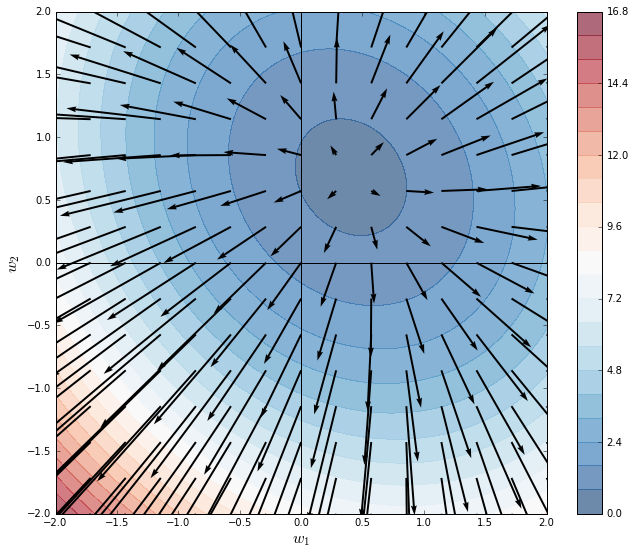

In [148]:
# compute error:
def mse(w_1,w_2):
    error = y-X.dot(np.array([w_1,w_2]))
    return np.mean(error**2)

# compute gradient:

def compute_gradient(w_1,w_2):
    grad = -0.5*(y-X.dot(np.array([w_1,w_2]))).T.dot(X)
    grad /= len(y)
    return grad
    
print(X.shape)
print(y.shape)

w1 = np.linspace(-2,2,100)
w2 = np.linspace(-2,2,100)
W1,W2 = np.meshgrid(w1, w2)
b = 0.5

f_W1W2 = np.zeros(W1.shape)
for i in range(W1.shape[0]):
    for j in range(W1.shape[1]):
        f_W1W2[i,j] = mse(W1[i,j],W2[i,j])
    
plt.figure(figsize=(11,9))

cs = plt.contourf(W1, W2, f_W1W2,20,cmap='RdBu_r',alpha=0.6);
plt.colorbar()
# contours = plt.contour(cs, colors='k')

w1 = np.linspace(-2,2,15)
w2 = np.linspace(-2,2,15)
W1,W2 = np.meshgrid(w1, w2)
grad1 = np.zeros(W1.shape)
grad2 = np.zeros(W1.shape)

for i in range(W1.shape[0]):
    for j in range(W1.shape[1]):
        grad1[i,j],grad2[i,j] = compute_gradient(W1[i,j],W2[i,j])
    
plt.quiver(W1,W2,grad1,grad2, color='k',angles='xy', scale_units='xy', scale=1,
             pivot = 'tail')
# plt.clabel(contours, inline=True, fontsize=14)
plt.xlabel('$w_1$', fontsize=16)
plt.ylabel('$w_2$', fontsize=16)
# plt.plot(w1[w2_plot>0],w2_plot[w2_plot>0], linewidth=5,color='r')
# plt.plot(w1[w2_plot>0],-w2_plot[w2_plot>0], linewidth=5,color='r')

plt.axhline(0, color='k')
plt.axvline(0, color='k')

### Gradient Descent
- Simple and often quite effective on ML tasks
- Often very scalable
- Only applies to smooth functions (differentiable)
- Might find a local minimum, rather than a global one

Algorithm:
- Choose a starting point (typically random or 0)
- While not converged, repeat:
    - compute gradient $\nabla L(w)$
    - choose a step size (fixed, line search, backtracking line search, schedule)
    - $w\leftarrow w - \eta\nabla L(w)\,.$
- Return after stopping criterion satisfied
    
An common stopping criterion is $||\nabla L(w)||_2<\epsilon$ where $\epsilon$ is a threshold picked in advance. In ML we are trying to minimize generalization loss and therefore can choose criteria such as early stopping that stops when validation error increases. Other fields might be more interested in parameter accuracy. 

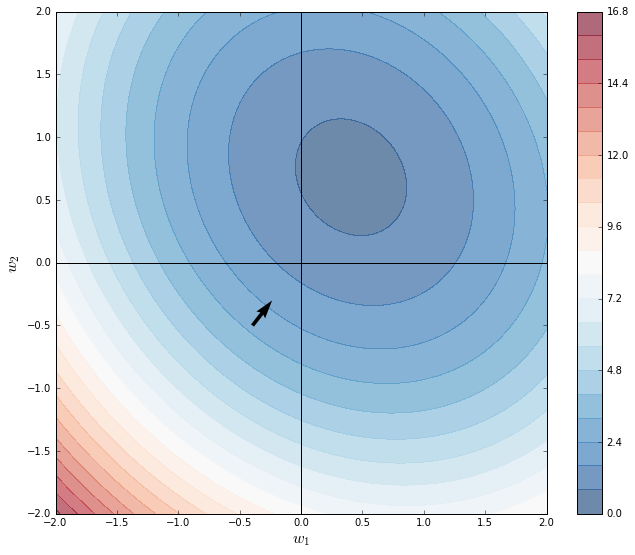

In [149]:
w1 = np.linspace(-2,2,100)
w2 = np.linspace(-2,2,100)
W1,W2 = np.meshgrid(w1, w2)
b = 0.5

f_W1W2 = np.zeros(W1.shape)
for i in range(W1.shape[0]):
    for j in range(W1.shape[1]):
        f_W1W2[i,j] = mse(W1[i,j],W2[i,j])
    
plt.figure(figsize=(11,9))

cs = plt.contourf(W1, W2, f_W1W2,20,cmap='RdBu_r',alpha=0.6);
plt.colorbar()
# contours = plt.contour(cs, colors='k')

w = [-0.4,-0.5]
gradw = compute_gradient(w[0],w[1])
lmbda = 0.3
step =  - gradw*lmbda
    
plt.quiver(w[0],w[1],step[0],step[1], color='k',angles='xy', scale_units='xy', scale=1,
             pivot = 'tail')
# plt.clabel(contours, inline=True, fontsize=14)
plt.xlabel('$w_1$', fontsize=16)
plt.ylabel('$w_2$', fontsize=16)

plt.axhline(0, color='k')
plt.axvline(0, color='k')

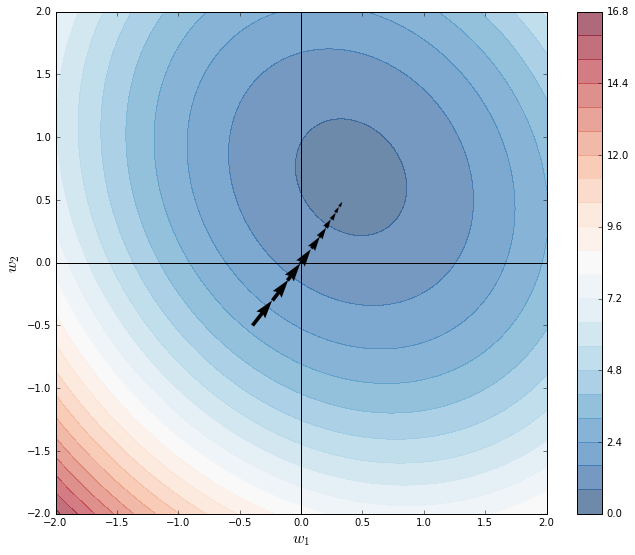

In [150]:
# take a few steps, play with step size, starting point

w1 = np.linspace(-2,2,100)
w2 = np.linspace(-2,2,100)
W1,W2 = np.meshgrid(w1, w2)
b = 0.5

f_W1W2 = np.zeros(W1.shape)
for i in range(W1.shape[0]):
    for j in range(W1.shape[1]):
        f_W1W2[i,j] = mse(W1[i,j],W2[i,j])
    
plt.figure(figsize=(11,9))

cs = plt.contourf(W1, W2, f_W1W2,20,cmap='RdBu_r',alpha=0.6);
plt.colorbar()
# contours = plt.contour(cs, colors='k')

w = [-0.4,-0.5]

lmbda = 0.3

for i in range(10):
    gradw = compute_gradient(w[0],w[1])
    step =  - gradw*lmbda

    plt.quiver(w[0],w[1],step[0],step[1], color='k',angles='xy', scale_units='xy', scale=1,
                 pivot = 'tail')
    w += step
    
# plt.clabel(contours, inline=True, fontsize=14)
plt.xlabel('$w_1$', fontsize=16)
plt.ylabel('$w_2$', fontsize=16)

plt.axhline(0, color='k')
plt.axvline(0, color='k')

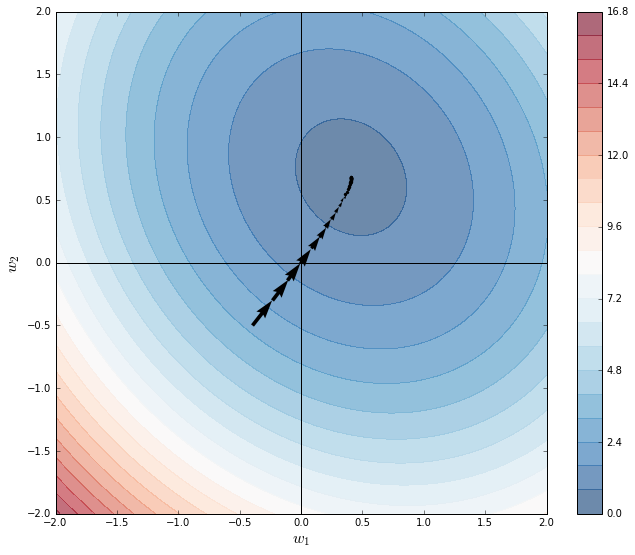

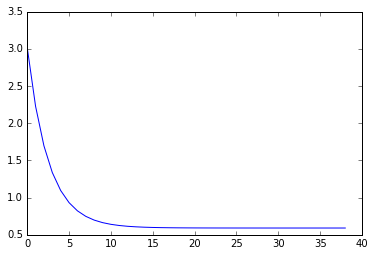

In [151]:
# set a convergence criteria

w1 = np.linspace(-2,2,100)
w2 = np.linspace(-2,2,100)
W1,W2 = np.meshgrid(w1, w2)
b = 0.5

f_W1W2 = np.zeros(W1.shape)
for i in range(W1.shape[0]):
    for j in range(W1.shape[1]):
        f_W1W2[i,j] = mse(W1[i,j],W2[i,j])
    
plt.figure(figsize=(11,9))

cs = plt.contourf(W1, W2, f_W1W2,20,cmap='RdBu_r',alpha=0.6);
plt.colorbar()
# contours = plt.contour(cs, colors='k')

w = [-0.4,-0.5]
lmbda = 0.3
gradw = compute_gradient(w[0],w[1])

train_loss = []

while np.linalg.norm(gradw)>0.001:
    step =  - gradw*lmbda
    plt.quiver(w[0],w[1],step[0],step[1], color='k',angles='xy', scale_units='xy', scale=1,
                 pivot = 'tail')
    train_loss.append(mse(w[0],w[1]))
    w += step
    gradw = compute_gradient(w[0],w[1])
    
# plt.clabel(contours, inline=True, fontsize=14)
plt.xlabel('$w_1$', fontsize=16)
plt.ylabel('$w_2$', fontsize=16)

plt.axhline(0, color='k')
plt.axvline(0, color='k')

plt.figure()
plt.plot(train_loss)

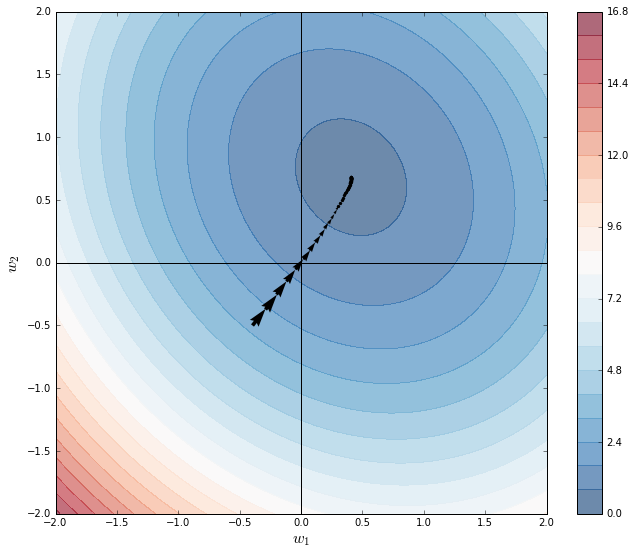

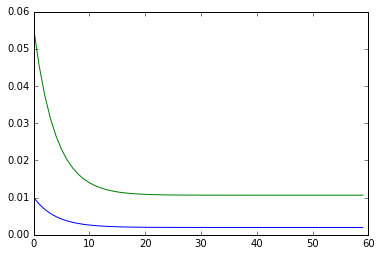

In [153]:
# use early stopping (simple example)

def mse_val(w_1,w_2):
    error = yval-Xval.dot(np.array([w_1,w_2]))
    return np.mean(error**2)

w1 = np.linspace(-2,2,100)
w2 = np.linspace(-2,2,100)
W1,W2 = np.meshgrid(w1, w2)
b = 0.5

f_W1W2 = np.zeros(W1.shape)
for i in range(W1.shape[0]):
    for j in range(W1.shape[1]):
        f_W1W2[i,j] = mse(W1[i,j],W2[i,j])
    
plt.figure(figsize=(11,9))

cs = plt.contourf(W1, W2, f_W1W2,20,cmap='RdBu_r',alpha=0.6);
plt.colorbar()
# contours = plt.contour(cs, colors='k')

w = [-0.4,-0.5]

lmbda = 0.2
gradw = np.zeros(2)+np.inf

train_loss = []
val_loss = []

while np.linalg.norm(gradw)>0.001:
    old_w = w
    gradw = compute_gradient(w[0],w[1])
    step =  - gradw*lmbda
    plt.quiver(w[0],w[1],step[0],step[1], color='k',
               angles='xy', scale_units='xy', scale=1,
               pivot = 'tail')
    train_loss.append(mse(w[0],w[1])/300)
    vloss = mse_val(w[0],w[1])/50
    if len(val_loss):
        if val_loss[-1] < vloss: 
            # don't make this update and stop
            w = old_w
            print('early stopping')
            break
    val_loss.append(vloss)
    w += step
    
# plt.clabel(contours, inline=True, fontsize=14)
plt.xlabel('$w_1$', fontsize=16)
plt.ylabel('$w_2$', fontsize=16)

plt.axhline(0, color='k')
plt.axvline(0, color='k')

plt.figure()
plt.plot(train_loss)
plt.plot(val_loss)

### Stochastic Gradient Descent

Typically, the loss is a sum over the loss for each individual point: $ L(w) = \frac{1}{n}\sum_{i=1}^n L_i(w)$.

We use $\nabla L_i(w)$ instead of $\nabla L(w)$. Since we sample over the points uniformly, they all have equal proability, and the expected value of $\nabla L_i(w)$ is:

$E_I\nabla L_i(w) = \sum_{i=1}^n P(i)L_i(w) = \frac{1}{n}\sum_{i=1}^n L_i(w) = \nabla L(w)$.

- $\nabla L_i(w)$ is faster to compute
- we make n updates for each epoch
- $\nabla L_i(w)$ has higher variance than $\nabla L(w)$ and therefore introduces noise into the trajectory. However, this still leads to a much faster convergence and the noise can be beneficial as it allows for some exploration.
- SGD converges in $O(1/\epsilon)$ and GD in $O(1/\log\epsilon)$ steps. However, in practice it is much faster


Algorithm:
- Choose a starting point (typically random or 0)
- While not converged, repeat:
    - for each point $i$ in a reshuffled order of the points: 
        - compute gradient $\nabla L_i(w)$
        - choose a step size (start large and decrease) 
        - $w\leftarrow w - \eta\nabla L_i(w)\,.$
- Return after stopping criterion satisfied
 
 


In [154]:
# X, y = datasets.load_diabetes(return_X_y=True)
data = datasets.load_diabetes()
data['data'] = np.nan_to_num(zscore(data['data']))
# train data
X = data['data'][:10,np.array([0,1])]
y = X.dot(np.array([0.4,0.7]))+0.5*np.random.normal(size=10)
# validation data
Xval = data['data'][300:350,np.array([0,1])]
yval = Xval.dot(np.array([0.4,0.7]))+0.5*np.random.normal(size=50)
# test data
Xtest = data['data'][350:400,np.array([0,1])]
ytest = Xtest.dot(np.array([0.4,0.7]))+0.5*np.random.normal(size=50)

def mse(w_1,w_2):
    error = y-X.dot(np.array([w_1,w_2]))
    return np.mean(error**2)

def mse_val(w_1,w_2):
    error = yval-Xval.dot(np.array([w_1,w_2]))
    return np.mean(error**2)

iteration count 0
iteration count 1
iteration count 2
early stopping


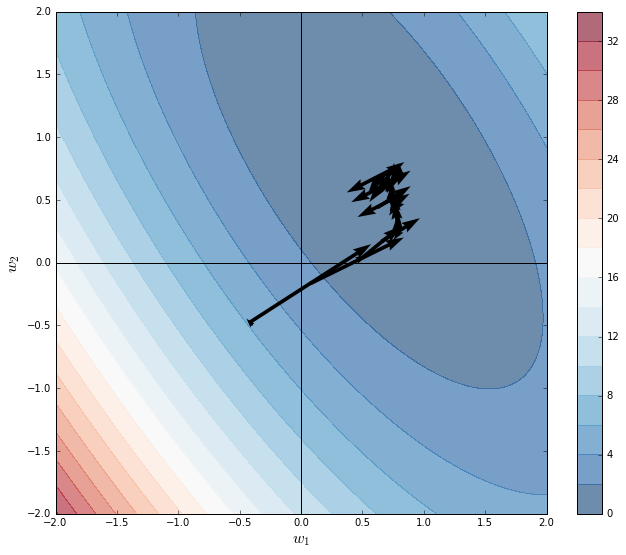

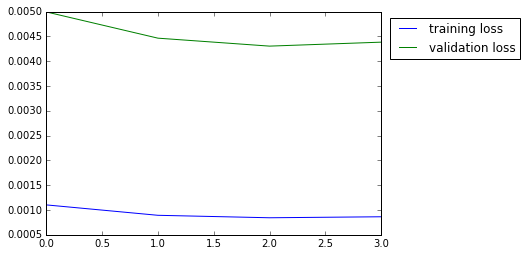

In [158]:
# stochastic gradient descent with early stopping


def compute_gradient_i(i,w_1,w_2):
    grad = -0.5*(y[i]-X[i:i+1].dot(np.array([w_1,w_2]))).T.dot(X[i:i+1])
    return grad

w1 = np.linspace(-2,2,100)
w2 = np.linspace(-2,2,100)
W1,W2 = np.meshgrid(w1, w2)
b = 0.5

f_W1W2 = np.zeros(W1.shape)
for i in range(W1.shape[0]):
    for j in range(W1.shape[1]):
        f_W1W2[i,j] = mse(W1[i,j],W2[i,j])
    
plt.figure(figsize=(11,9))

cs = plt.contourf(W1, W2, f_W1W2,20,cmap='RdBu_r',alpha=0.6);
plt.colorbar()
# contours = plt.contour(cs, colors='k')

w = [-0.4,-0.5]

lmbda = 0.2
gradw = np.zeros(2)+np.inf

train_loss = []
val_loss = []

n = len(y)
from random import shuffle
max_count = 20
count = 0

while count<max_count:
    # randomized order
    w_old = w
    sample_order = np.arange(n)
    shuffle(sample_order)
    for i in range(n):
        gradw = compute_gradient_i(sample_order[i],w[0],w[1])
        step =  - gradw*lmbda
        if i%1 ==0: # plot only some gradients
            plt.quiver(w[0],w[1],step[0],step[1], color='k',
                       angles='xy', scale_units='xy', scale=0.5,
                       pivot = 'tail')
        w += step
    train_loss.append(mse(w[0],w[1])/300)
    vloss = mse_val(w[0],w[1])/50
    val_loss.append(vloss)
    if len(val_loss)>1:
        if val_loss[-2] < vloss:
            print('early stopping')
            w = w_old
            break
    print('iteration count {}'.format(count))
    count+=1
    
        
# plt.clabel(contours, inline=True, fontsize=14)
plt.xlabel('$w_1$', fontsize=16)
plt.ylabel('$w_2$', fontsize=16)

plt.axhline(0, color='k')
plt.axvline(0, color='k')

plt.figure()
plt.plot(train_loss,label='training loss')
plt.plot(val_loss,label='validation loss')
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')

### Batch gradient descent



### Other examples / more complex objective



### Loss functions
